In [1]:
versionname = "aligned-heuristic"
original = False

In [2]:
## Imports

import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
k = 30
nbags = 10
bag_contfactor = .4
seed = 1302

In [4]:
## Construct dataset
# 15 bags
# 35 instances/bag
import sys
from create_dsNormals import gen_data
import sys
sys.path.insert(1, '../')
from dataBag import DataBag
from rewardInfo import RewardInfo
from data import Data

In [5]:
from data import Data
from methods import MABMethod
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve
from itertools import cycle

def getPrediction(alba: MABMethod, data: Data):
    pos = {}
    neg = {}
    probabilities = alba.predict(data, True)
    return probabilities
    '''for key in predictions.keys():
        posdummy = []
        negdummy = []
        for i in range(len(predictions[key])):
            if predictions[key][i]==-1:
                negdummy.append(data.get_domain(key)[i])
            elif predictions[key][i]==1:
                posdummy.append(data.get_domain(key)[i])
        pos[key] = np.asarray(posdummy)
        neg[key] = np.asarray(negdummy)
    return neg, pos, predictions'''

def diff2dd(A, B):
    # https://stackoverflow.com/questions/8317022/get-intersecting-rows-across-two-2d-numpy-arrays
    nrows, ncols = A.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
        'formats':ncols * [A.dtype]}

    C = np.setdiff1d(A.view(dtype), B.view(dtype))

    # This last bit is optional if you're okay with "C" being a structured array...
    C = C.view(A.dtype).reshape(-1, ncols)
    return C

    
def noisyOr(labels):
    lst = np.zeros((len(labels.keys())))
    for bag in labels.keys():
        lbls = np.array(labels[bag])
        lbls = 1-lbls
        lst[bag] = 1-np.prod(lbls)
    return lst

def currentPrediction(alba, data, bags, newinstanceKey, instance, labeledPos = None, labeledNeg = None, t=0, i=0, y_inst = [], lastt = False, rewardInfo = None, bags_labels=[]):
    

    cycol = cycle(clrs)

    fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(16,9)) 

    


    for bag in range(len(bags)):
        domain = bags[bag]
        pos = np.asarray(labeledPos[bag])
        neg = np.asarray(labeledNeg[bag])
        domain = diff2dd(domain, pos)
        domain = diff2dd(domain, neg)
        c = next(cycol)

        if (len(domain)>0):
            ax.scatter(domain[:,0], domain[:,1], c=c)
        
        if (len(pos)>0):
            ax.scatter(pos[:,0], pos[:,1], marker = '+', c=c)
        if (len(neg)>0):
            ax.scatter(neg[:,0], neg[:,1], marker = '_', c=c)


    plt.title('Iteration '+str(t).zfill(3))
    fig.savefig('img/iteration'+str(t).zfill(3)+'.png',bbox_inches='tight')
    plt.close()



    probabilities = getPrediction(alba, data)
    '''nrows = 3
    ncols = 4
    fig, axs = plt.subplots( nrows=nrows, ncols=ncols ,figsize=(16,9)) 
   
    for bag in range(len(bags)):
        ax = axs[bag//ncols, bag-ncols*(bag//ncols)]
        domain = bags[bag]
        ax.scatter(domain[:,0], domain[:,1], c =probabilities[bag], cmap = 'gray')
        if (bag == newinstanceKey):
            ax.scatter(instance[0], instance[1], c='red')


    plt.title('Iteration '+str(t).zfill(3))
    fig.savefig('colorimg/iteration'+str(t).zfill(3)+'.png',bbox_inches='tight')
    plt.close(fig)'''




    fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(16,9)) 
    domain = np.zeros((0,2))
    prs = np.zeros((0))
    for bag in range(len(bags)):
        domain = np.concatenate((domain,bags[bag]))
        prs = np.concatenate((prs, probabilities[bag]))
    
    '''z = ax.scatter(domain[:,0], domain[:,1], c = prs  , cmap = 'coolwarm',  s=200, edgecolors='k')
    ax.scatter(instance[0], instance[1],c='lime',label = "Selected instance",s=400, edgecolors='k')
    '''

    scoreroc = roc_auc_score(np.rint(y_inst), prs)
    # Data to plot precision - recall curve
    precision, recall, _ = precision_recall_curve(np.rint(y_inst), prs)
    # Use AUC function to calculate the area under the curve of precision recall curve
    scorepr = auc(recall, precision)
    '''bagprobs = noisyOr(probabilities)
    scorerocBag = roc_auc_score(np.rint(bags_labels), bagprobs)
    # Data to plot precision - recall curve
    precision, recall, _ = precision_recall_curve(np.rint(bags_labels), bagprobs)
    # Use AUC function to calculate the area under the curve of precision recall curve
    scoreprBag = auc(recall, precision)'''

    plt.title('Iteration '+str(t).zfill(3), fontsize = 16)
    plt.close()
    rewardInfo.updateAuc("roc", scoreroc)
    rewardInfo.updateAuc("pr", scorepr)
    '''rewardInfo.updateAuc("rocbag", scorerocBag)
    rewardInfo.updateAuc("prbag", scoreprBag)'''

    
    #textstr = "ROC AUC = {:.10f}\nPR AUC = {:.10f}\nROC AUC BAG= {:.10f}\nPR AUC BAG= {:.10f}".format(scoreroc, scorepr, scorerocBag, scoreprBag)
    textstr = "ROC AUC = {:.10f}\nPR AUC = {:.10f}".format(scoreroc, scorepr)
    
    if lastt:
        rewardInfo.updateAuc("rocs",scoreroc)
        rewardInfo.updateAuc("prs", scorepr)
        '''rewardInfo.updateAuc("prsbag", scoreprBag)
        rewardInfo.updateAuc("rocsbag", scorerocBag)'''

    
    '''textstr = "ROC AUC = {:.10f}\nPR AUC = {:.10f}".format(scoreroc, scorepr)
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='right', bbox=props)
    
    cbar = fig.colorbar(z,ax= ax, label ="higher score = more positive")
    tick_font_size = 14
    cbar.ax.tick_params(labelsize=tick_font_size)
    plt.rcParams.update({'font.size': 14})
    ax.legend(loc = "lower right", fontsize= 14)

    fig.savefig('colorimg2/iteration'+str(t).zfill(3)+'.png',bbox_inches='tight')
    plt.close(fig)
    '''

In [41]:
nmbr = k
z = 0
while nmbr>0:
    print(nmbr)
    bags, bags_labels, X_inst, y_inst = gen_data(k = k, nbags = nbags, bag_contfactor = bag_contfactor, seed = seed, maxAnoms=nmbr)
    D = bags
    bags = np.array(list(D.values()))

    dataBag = DataBag(bags, bags_labels, X_inst, y_inst)
    if (len(bags_labels) != z):
        z = len(bags_labels)
        rewardInfo = RewardInfo(z)

    ## Create toy data set
    clrs = ['b','g','r','c','m','k','y', 'lime','deeppink','aqua','yellow','gray','darkorange','saddlebrown','salmon']

    cycol = cycle(clrs)

    fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (15,9) )  # create figure & 1 axis

    for bag in range(len(bags)):
        domain = bags[bag]
        anomalies = []
        normals = []
        D[bag] = np.asarray(domain.tolist())

        for idx in range(len(domain)):
            if dataBag.isAnomaly(bag, idx):
                anomalies.append(domain[idx])
            else:
                normals.append(domain[idx])

        anomalies = np.asarray(anomalies)
        normals = np.asarray(normals)
        
        c=next(cycol)
        if (len(normals)>0):
            ax.scatter(normals[:,0], normals[:,1], marker='.', c=c, s=200, label = "Bag "+str(bag))#, c= 'b')
        if (len(anomalies)>0):
            ax.scatter(anomalies[:,0], anomalies[:,1],  marker='+', c=c, s=200, label = "Anomalies")#,c= 'b')

    '''for bag in range(len(bags)):
        domain = bags[bag]
        if (len(domain)>0):
            ax.scatter(domain[:,0], domain[:,1], c=next(cycol))'''
            

    plt.title("Generated 2D Toy Data Set -- "+str(nmbr/k))
    plt.legend()
    fig.savefig('img/'+str(nmbr/k)+versionname+'.png',bbox_inches='tight')
    plt.close(fig)


    ## Create 2 domains
    training_data = Data(nbags)
    training_data.set_domains_and_labels(D)
    query_budget = 20# nbags*k#30# 30*10
    alba = MABMethod(mab="rotting-swa", query_budget=query_budget, verbose=True, rewardInfo=rewardInfo , al_strategy = "entropy")

    if (original):
        t = 0  
        labeledPos = {}
        labeledNeg = {}
        for bag in range(len(bags)):
            labeledNeg[bag] = []
            labeledPos[bag] = []
        performance = []

        import warnings
        warnings.filterwarnings('ignore')

        while(t<query_budget):
            queries = alba.fit_query(training_data, True)

            #!!!!!!!
            key,idx = queries[0]
            i = 0
            while dataBag.isLabeled(key,idx):
                i+=1
                key, idx = queries[i]
                
            rewardInfo.chooseArm(key)
            key,idx = queries[i]
            instance = training_data.get_domain(key)[idx]
            lbl = dataBag.getLabel(key, idx)
            training_data.set_new_label(key, idx, lbl)
            training_data.set_last_labeled(key,idx)
            dataBag.label(key,idx)
            if (lbl == 1):
                labeledPos[key].append(instance.tolist())
            else:
                labeledNeg[key].append(instance.tolist())

            currentPrediction(alba, training_data, bags, key, instance, labeledPos,labeledNeg, t, bags_labels=bags_labels,i=i, y_inst = y_inst, lastt = (t==query_budget-1), rewardInfo = rewardInfo)
            
            #performance.append(dataBag.measureAccuracy(predictions))
            print(t)
            t += 1

        ## window = 10!!!


        ## NEW !!!
    if not original:
        from distributionAligner import NormalAligner

        aligner = NormalAligner()
        D, X_inst = aligner.align(D)
        bags = np.array(list(D.values()))

        from itertools import cycle
        cycol = cycle(clrs)

        fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (15,9) )  # create figure & 1 axis

        for bag in range(len(bags)):
            domain = bags[bag]
            anomalies = []
            normals = []
            D[bag] = np.asarray(domain.tolist())

            for idx in range(len(domain)):
                if dataBag.isAnomaly(bag, idx):
                    anomalies.append(domain[idx])
                else:
                    normals.append(domain[idx])

            anomalies = np.asarray(anomalies)
            normals = np.asarray(normals)
            
            c=next(cycol)
            if (len(normals)>0):
                ax.scatter(normals[:,0], normals[:,1], marker='.', c=c, s=200, label = "Bag "+str(bag))#, c= 'b')
            if (len(anomalies)>0):
                ax.scatter(anomalies[:,0], anomalies[:,1],  marker='+', c=c, s=200, label = "Anomalies")#,c= 'b')   

        '''for bag in range(len(bags)):
            domain = bags[bag]
            if (len(domain)>0):
                ax.scatter(domain[:,0], domain[:,1], c=next(cycol))'''
                

        #fig.savefig('img/original.png',bbox_inches='tight')
        plt.title('Aligned 2D Toy Data Set')
        plt.legend()
        fig.savefig('img/'+str(nmbr/k)+versionname+'.png',bbox_inches='tight')
        plt.close(fig)
        training_data = Data(nbags)
        training_data.set_domains_and_labels(D)
        query_budget = 20#nbags*k# 30# 30*10
        alba = MABMethod(mab="rotting-swa", query_budget=query_budget, verbose=True, rewardInfo=rewardInfo , al_strategy = "entropy")

        t = 0  
        labeledPos = {}
        labeledNeg = {}
        for bag in range(len(bags)):
            labeledNeg[bag] = []
            labeledPos[bag] = []
        performance = []

        import warnings
        warnings.filterwarnings('ignore')

        while(t<query_budget):
            queries = alba.fit_query(training_data, True)

            #!!!!!!!
            key,idx = queries[0]
            i = 0
            while dataBag.isLabeled(key,idx):
                i+=1
                key, idx = queries[i]
                
            rewardInfo.chooseArm(key)
            key,idx = queries[i]
            instance = training_data.get_domain(key)[idx]
            lbl = dataBag.getLabel(key, idx)
            training_data.set_new_label(key, idx, lbl)
            training_data.set_last_labeled(key,idx)
            dataBag.label(key,idx)
            if (lbl == 1):
                labeledPos[key].append(instance.tolist())
            else:
                labeledNeg[key].append(instance.tolist())

            currentPrediction(alba, training_data, bags, key, instance, labeledPos,labeledNeg, t, bags_labels=bags_labels,i=i, y_inst = y_inst, lastt = (t==query_budget-1), rewardInfo = rewardInfo)
            
            #performance.append(dataBag.measureAccuracy(predictions))
            print(t)
            t += 1

        ## window = 10!!!
    
    nmbr -= 1



30
none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
29
none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
28
none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
27
none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
26
none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
25
none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
24
none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
23
none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
22
none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
21
none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
19
none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
18
none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
17
none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
16
none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
15
none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
14
none
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
13
none
0
1
2


KeyboardInterrupt: 

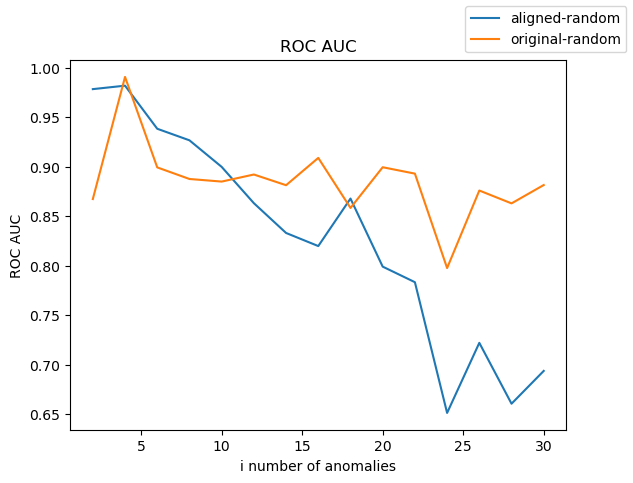

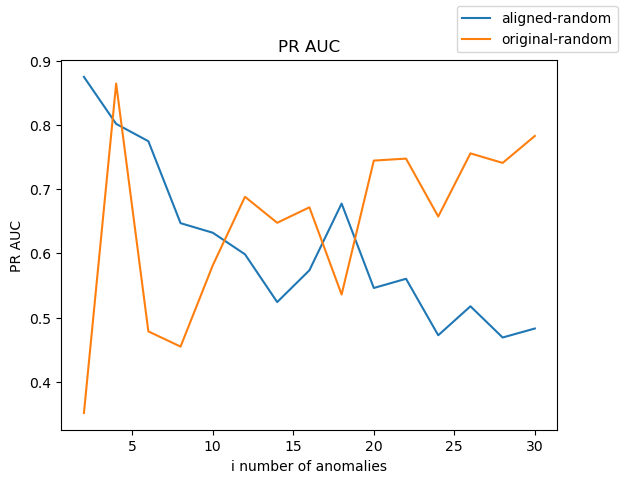

'cycol = cycle(clrs)\nfig, ax = plt.subplots( nrows=1, ncols=1)#, figsize = (16,9) ) \nscores = rewardInfo.getAUC()["rocsbag"]\nimport csv\nwith open(\'auc_roc_bag.csv\', \'r\') as readFile:\n    reader = csv.reader(readFile)\n    lines = list(reader)\n    flag = True\n    for i in range(len(lines)):\n        if lines[i][0] == versionname:\n            lines[i] = [versionname] + scores\n            flag = False\n    if flag:\n        lines.append([versionname] + scores)\n        \nwith open(\'auc_roc_bag.csv\', \'w\',newline=\'\') as writeFile:\n    writer = csv.writer(writeFile)\n    writer.writerows(lines)\n\nfor line in lines:\n    ax.plot([k-3*i for i in range(len(line[1:]))],[float(i) for i in line[1:]], label = line[0])\nplt.title(\'ROC AUC BAG-LEVEL\')\nplt.ylabel(\'ROC AUC\')\nplt.xlabel(\'Round i\')\nfig.savefig(\'img/ROC AUC BAG.png\',bbox_inches=\'tight\')\nfig.legend()\nplt.show()\nplt.close(fig)\n\ncycol = cycle(clrs)\nfig, ax = plt.subplots( nrows=1, ncols=1)#, figsize = 

In [43]:
fig, ax = plt.subplots( nrows=1, ncols=1)#, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["rocs"]
import csv
with open('auc_rocs.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = True
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_rocs.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

for line in lines:
    if 'random' in line[0]:
        ax.plot([k-2*i for i in range(len(line[1:]))],[float(i) for i in line[1:]], label = line[0])
plt.title('ROC AUC')
plt.ylabel('ROC AUC')
plt.xlabel('i number of anomalies')
fig.legend()
fig.savefig('img/ROC AUC.png',bbox_inches='tight')
plt.show()
plt.close(fig)

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1)#, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["prs"]
import csv
with open('auc_prs.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = True
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_prs.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)


for line in lines:
    if 'random' in line[0]:
        ax.plot([k-2*i for i in range(len(line[1:]))],[float(i) for i in line[1:]], label = line[0])
plt.title('PR AUC')
plt.ylabel('PR AUC')
plt.xlabel('i number of anomalies')
fig.legend()
plt.show()
fig.savefig('img/PR AUC.png',bbox_inches='tight')
plt.close(fig)


## BAGLEVEL

'''cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1)#, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["rocsbag"]
import csv
with open('auc_roc_bag.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = True
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_roc_bag.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

for line in lines:
    ax.plot([k-3*i for i in range(len(line[1:]))],[float(i) for i in line[1:]], label = line[0])
plt.title('ROC AUC BAG-LEVEL')
plt.ylabel('ROC AUC')
plt.xlabel('Round i')
fig.savefig('img/ROC AUC BAG.png',bbox_inches='tight')
fig.legend()
plt.show()
plt.close(fig)

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1)#, figsize = (16,9) ) 
scores = rewardInfo.getAUC()["prsbag"]
import csv
with open('auc_pr_bag.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    flag = True
    for i in range(len(lines)):
        if lines[i][0] == versionname:
            lines[i] = [versionname] + scores
            flag = False
    if flag:
        lines.append([versionname] + scores)
        
with open('auc_pr_bag.csv', 'w',newline='') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)

for line in lines:
    ax.plot([k-3*i for i in range(len(line[1:]))],[float(i) for i in line[1:]], label = line[0])
plt.title('PR AUC BAG-LEVEL')
plt.ylabel('PR AUC')
plt.xlabel('Round i')
fig.savefig('img/PR AUC BAG.png',bbox_inches='tight')
fig.legend()
plt.show()
plt.close(fig)'''